# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import seaborn as sns

In [102]:
from services.load_s3 import upload_to_yandex_s3

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['figure.figsize'] = (10,5)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [6]:
tracks = pd.read_parquet("./datasets/tracks.parquet")

In [7]:
catalog_names = pd.read_parquet("./datasets/catalog_names.parquet")

In [8]:
interactions = pd.read_parquet("./datasets/interactions.parquet")

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [8]:
# функция для знакомства с данными
def df_info(df):
    display("Фрагмент датасета")
    display(df.sample(5))
    display("-------------------------")
    display("Проверяем на наличие пропущенных значение")
    display(df.isna().sum())
    display("-------------------------")
    display("Информация о датасете")
    display(df.info())
    display("-------------------------")
    display("Размерность")
    display(df.shape)

## Данные о треках 

In [11]:
df_info(tracks)

'Фрагмент датасета'

,track_id,albums,artists,genres
795903,62161836,"[9770137, 9770172, 9772480, 9774345, 9776369]",[29063],"[14, 102]"
907042,76669103,"[13544471, 16291406]",[7013449],[11]
899035,75020911,[13149771],[593930],[25]
544460,37629201,[4620193],"[2922297, 3444221, 5117765]","[3, 75]"
335967,21781682,"[2501206, 2528360, 2538175, 2553777, 2659183, ...","[457446, 1433418]",[11]


'-------------------------'

'Проверяем на наличие пропущенных значение'

track_id    0
albums      0
artists     0
genres      0
dtype: int64

'-------------------------'

'Информация о датасете'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


None

'-------------------------'

'Размерность'

(1000000, 4)

С виду явных проблем нет, идентификаторы менять не стоит. Но видно что данные в столбцах кроме track_id содержат массивы, очевидно что пустой массив это не пропущенное значение, хотя данных не содержит. Проведу проверку.

In [13]:
# функция для поиска пустых массивов.
def missed_value(df, column):
    df_missed_value =df[df[column].apply(lambda x: len(x) == 0)]
    return df_missed_value

In [10]:
missed_value(tracks, 'artists')

,track_id,albums,artists,genres
146031,3599314,[389925],[],"[68, 86]"
146163,3599591,[389944],[],"[68, 86]"
177544,4790215,[533785],[],"[68, 86]"
218922,10063296,[1083742],[],"[11, 20]"
231455,12122918,[1315834],[],[68]
...,...,...,...,...
999868,101201589,[12649219],[],"[62, 77]"
999876,101219571,[9444321],[],"[62, 83, 77]"
999901,101243616,[11700332],[],"[62, 93]"
999920,101292599,[9331881],[],"[62, 90, 77, 84]"


In [11]:
missed_value(tracks, 'albums')

,track_id,albums,artists,genres
310821,20200372,[],[],[]
310826,20200380,[],[],[]
312469,20305116,[],[],[]
312474,20305121,[],[],[]
320353,20756854,[],[],[]
326588,21196099,[],[],[]
326592,21196103,[],[],[]
326594,21196105,[],[],[]
326596,21196107,[],[],[]
326598,21196109,[],[],[]


In [12]:
missed_value(tracks, 'genres')

,track_id,albums,artists,genres
490,2520,"[249, 163801, 163802, 324616, 17542430, 189498...",[2259],[]
3069,16776,"[1479, 5319, 6093, 8467, 10641, 90867, 163801,...",[978],[]
3077,16801,"[1479, 163801, 9287549, 9377183, 9424994, 1201...",[10520],[]
4192,23752,"[2001, 3722, 4973, 6104, 6558, 23866, 37052, 7...",[13373],[]
6645,38012,"[3147, 60099, 530836, 1115289, 2490724, 818446...",[16758],[]
...,...,...,...,...
997667,99412992,[20764551],[10029101],[]
999192,100497082,[21098340],[15936615],[]
999703,100923319,[21233460],[5271861],[]
999704,100923322,[21233460],[5271861],[]


В датафрейме есть строки с неизвестными исполнителями, альбомами и жанрами. Для принятия решения что делать с этими строками изучу какой процент от общих они составляют.

In [9]:
missing_values = tracks[
    (tracks['artists'].str.len() == 0) | (tracks['albums'].str.len() == 0) | (tracks['genres'].str.len() == 0)]

In [10]:
percent_missing_values = len(missing_values) / len(tracks) * 100
print(f"Процент данных в missing_values от общего количества данных в tracks: {percent_missing_values:.1f}%")

Процент данных в missing_values от общего количества данных в tracks: 1.9%


Менее 3%, считаю что могу их просто удалить.

In [11]:
indexes_to_drop = missing_values.index

In [12]:
tracks = tracks.drop(indexes_to_drop).reset_index(drop=True)

In [143]:
missed_value(tracks, 'albums')

,track_id,albums,artists,genres


In [13]:
del missing_values

In [14]:
# проверка все ли треки из каталога содержаться в справочнике
# извлекаю все track_id из catalog_names
track_ids = catalog_names[catalog_names['type'] == 'track']['id'].tolist()

# проверяю, содержатся ли все track_id в tracks
all_exist = all(
    track_id in tracks['track_id'].values for track_id in track_ids
)

if all_exist:
    print("Не все track_id из каталога присутствуют в справочнике.")
else:
    print("Все track_id из каталога присутствуют в справочнике.")

Все track_id из каталога присутствуют в справочнике.


In [15]:
del track_ids

In [16]:
# проверка все ли альбомы из каталога содержаться в справочнике
alb_exist = (
    set(tracks['albums'].explode().drop_duplicates()) 
    - set(catalog_names.query('type == "album"')['id'])
)
if alb_exist:
    print("Не все album из каталога присутствуют в справочнике.")
else:
    print("Все album из каталога присутствуют в справочнике.")

Все album из каталога присутствуют в справочнике.


In [17]:
# проверка все ли артисты из каталога содержаться в справочнике
art_exist = (
    set(tracks['artists'].explode().drop_duplicates()) 
    - set(catalog_names.query('type == "artist"')['id'])
)
if art_exist:
    print("Не все artists из каталога присутствуют в справочнике.")
else:
    print("Все artists из каталога присутствуют в справочнике.")

Все artists из каталога присутствуют в справочнике.


In [18]:
# проверка все ли жанры из каталога содержаться в справочнике
gen_exist = (
    set(tracks['genres'].explode().drop_duplicates()) 
    - set(catalog_names.query('type == "genre"')['id'])
)
if gen_exist:
    print("Не все genres из каталога присутствуют в справочнике.")
else:
    print("Все genres из каталога присутствуют в справочнике.")

Не все genres из каталога присутствуют в справочнике.


А вот это уже хуже. Нужно было предположить такой ход на этапе когда удалял пустые значения. Посмотрим что с этим делать.

In [88]:
len(gen_exist)

30

Получается у 30 идентификаторов жанров неизвестны. Нужно понять сколько треков с необозначенными жанрами.

In [19]:
track_unknown_genres = (
    tracks
    .explode('genres')
    .query('genres in @gen_exist') 
    ['track_id']
    .drop_duplicates()
)

percent_unknown_genres = len(track_unknown_genres) / len(tracks) * 100
print(f"Процент треков с неизвестным жанром: {percent_unknown_genres:.1f}%")

Процент треков с неизвестным жанром: 4.9%


Удаляю, процент все равно не большой, причина такой неконсистентности не выяснена.

In [20]:
tracks = (
    tracks
    .query('track_id not in @track_unknown_genres')
    .reset_index(drop=True)
)

In [21]:
del gen_exist
del track_unknown_genres

In [22]:
# посмотрим как теперь выглядит каталог треков
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932664 entries, 0 to 932663
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   track_id  932664 non-null  int64 
 1   albums    932664 non-null  object
 2   artists   932664 non-null  object
 3   genres    932664 non-null  object
dtypes: int64(1), object(3)
memory usage: 28.5+ MB


## Имена артистов, названия альбомов, треков и жанров

In [44]:
df_info(catalog_names)

'Фрагмент датасета'

,id,type,name
1320523,35224081,track,Московская осень
1658876,68102867,track,The King
1126114,20360394,track,I Am Onslaught
1030719,10011772,track,А в деревне клёво
1181679,24788003,track,Army


'-------------------------'

'Проверяем на наличие пропущенных значение'

id      0
type    0
name    0
dtype: int64

'-------------------------'

'Информация о датасете'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


None

'-------------------------'

'Размерность'

(1812471, 3)

In [45]:
# детально посмотрю на данные внутри.
catalog_names.describe(include='all')

,id,type,name
count,1.812471e+06,1812471,1812471
unique,NaN,4,945118
top,NaN,track,Сборник
freq,NaN,1000000,778
mean,2.321647e+07,NaN,NaN
std,2.526044e+07,NaN,NaN
min,0.000000e+00,NaN,NaN
25%,3.480524e+06,NaN,NaN
50%,1.211436e+07,NaN,NaN
75%,3.773817e+07,NaN,NaN


В целом данные выглядят прилично, пропусков нет, типы данных соответсвуют. Если нет дубликатов, полагаю можно оставить как есть.

In [46]:
# проверю неявные дубликаты в колонке с типом
print(catalog_names['type'].unique())

['album' 'artist' 'genre' 'track']


In [47]:
# дубликаты по связке имя-тип
len(catalog_names[(catalog_names.duplicated(['id','type']) == True)])

0

In [48]:
# дубликаты по связке тип и наименование
len(catalog_names[(catalog_names.duplicated(['type','name']) == True)])

689769

In [54]:
print(f"Процент дубликатов по связке 'type','name':{len(catalog_names[(catalog_names.duplicated(['type','name']) == True)])/len(catalog_names):.2f}%")

Процент дубликатов по связке 'type','name':0.38%


In [23]:
# группировка по 'type' и 'name', а затем отбор групп, где количество записей больше 1
duplicate_counts = (catalog_names
                    .groupby(['type', 'name'])
                    .filter(lambda x: len(x) > 1)
                    .groupby(['type', 'name'])
                    .size())

# преобразование Series в DataFrame для удобства чтения
duplicate_counts_df = duplicate_counts.reset_index(name='duplicate_count')

# Количество дубликатов по связке 'type' и 'name'
print(duplicate_counts_df.sample(5))

         type                name  duplicate_count
164911  track                Бунт                5
55303   album  TOKYO - CITY POP -                3
113036  track        I Gotta Know                6
196335  track   Термоядерный СВЭГ                2
157080  track         Weg Von Dir                2


In [24]:
counts = duplicate_counts_df.groupby('type')['duplicate_count'].sum()

# Достаем количество дубликатов для 'album' и 'track'
album_duplicates_count = counts.get('album', 0)
track_duplicates_count = counts.get('track', 0)

# Вывод результата
print(f"Количество дубликатов для album: {album_duplicates_count}")
print(f"Количество дубликатов для track: {track_duplicates_count}")

Количество дубликатов для album: 298518
Количество дубликатов для track: 590064


Дубликатов по связке 'type','name' очень много, 38% от общих данных. Удалять такое количество нельзя, оставлю как есть. 

In [25]:
# уборочка
del duplicate_counts
del duplicate_counts_df
del counts
del album_duplicates_count
del track_duplicates_count

## Данные о том, какие пользователи прослушали тот или иной трек

In [22]:
df_info(interactions)

'Фрагмент датасета'

,user_id,track_id,track_seq,started_at
216,1221651,70471517,217,2022-11-16
4,837537,439925,5,2022-07-16
181,798669,51452575,182,2022-10-19
40,1077074,417949,41,2022-03-31
145,111758,22425013,146,2022-08-16


'-------------------------'

'Проверяем на наличие пропущенных значение'

user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64

'-------------------------'

'Информация о датасете'

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


None

'-------------------------'

'Размерность'

(222629898, 4)

In [22]:
len(interactions[(interactions.duplicated(['user_id','track_id']) == True)])

0

In [26]:
interactions.describe(include='all')

,user_id,track_id,track_seq,started_at
count,2.226299e+08,2.226299e+08,2.226299e+08,222629898
mean,6.875767e+05,3.653622e+07,4.621403e+02,2022-08-29 16:39:44.541336320
min,0.000000e+00,2.600000e+01,1.000000e+00,2022-01-01 00:00:00
25%,3.433710e+05,1.480849e+07,5.600000e+01,2022-07-02 00:00:00
50%,6.879730e+05,3.552474e+07,1.810000e+02,2022-09-15 00:00:00
75%,1.031127e+06,5.651137e+07,5.060000e+02,2022-11-09 00:00:00
max,1.374582e+06,1.015218e+08,1.663700e+04,2022-12-31 00:00:00
std,3.969033e+05,2.661782e+07,8.257312e+02,NaN


In [26]:
# все ли треки с которыми взаимодействовали, есть в справочнике.

missing_tracks = interactions[~interactions['track_id'].isin(tracks['track_id'])]
count_tracks = len(interactions['track_id'])
display('Неизвестных(не каталожных) треков от общего количества:'f'{len(missing_tracks)/count_tracks:.2%}')

'Неизвестных(не каталожных) треков от общего количества:3.55%'

Процент треков которых нет в tracks мал, удаляю без сожаления.

In [27]:
interactions = interactions[~interactions['track_id'].isin(missing_tracks['track_id'])]

# Проверяем количество треков после удаления
print(f'Количество треков после удаления неизвестных: {len(interactions)}')

Количество треков после удаления неизвестных: 214720738


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

1. **В датасете tracks в 15369 треков с неизвестным исполнителем, 3687 с неизвестным жанром и 18 с неизвестным альбомом. Всего процент потерянных данных составил 1.9%, поэтому принято решение их удалить. Также обнаружено что у 4.9% треков невозможно идентифицировать название жанра. Также удалены.**
2. **В датасете catalog_names задублированных значений по связке тип и наименование всего 689769. Оценочно это порядка 38% данных. Причина появления дубликатов не известна, не похоже на ошибку сбора информации. Полагаю удалять не следует.**
3. **В датасете interactions небольшой процент треков отсутствует в каталоге треков. Удалил.**

# === ЭТАП 2 ===

# EDA

### Распределение количества прослушанных треков.

In [191]:
interactions.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [192]:
print('Количество уникальных пользователей:{}'. format(interactions['user_id'].nunique()))

Количество уникальных пользователей:1372042


In [29]:
user_share_per_track = (
    interactions.groupby('user_id').agg(user_share=('track_id', 'count'))
)

In [30]:
user_share_per_track.describe().astype('int')

,user_share
count,1372042
mean,156
std,335
min,1
25%,22
50%,54
75%,149
max,16609


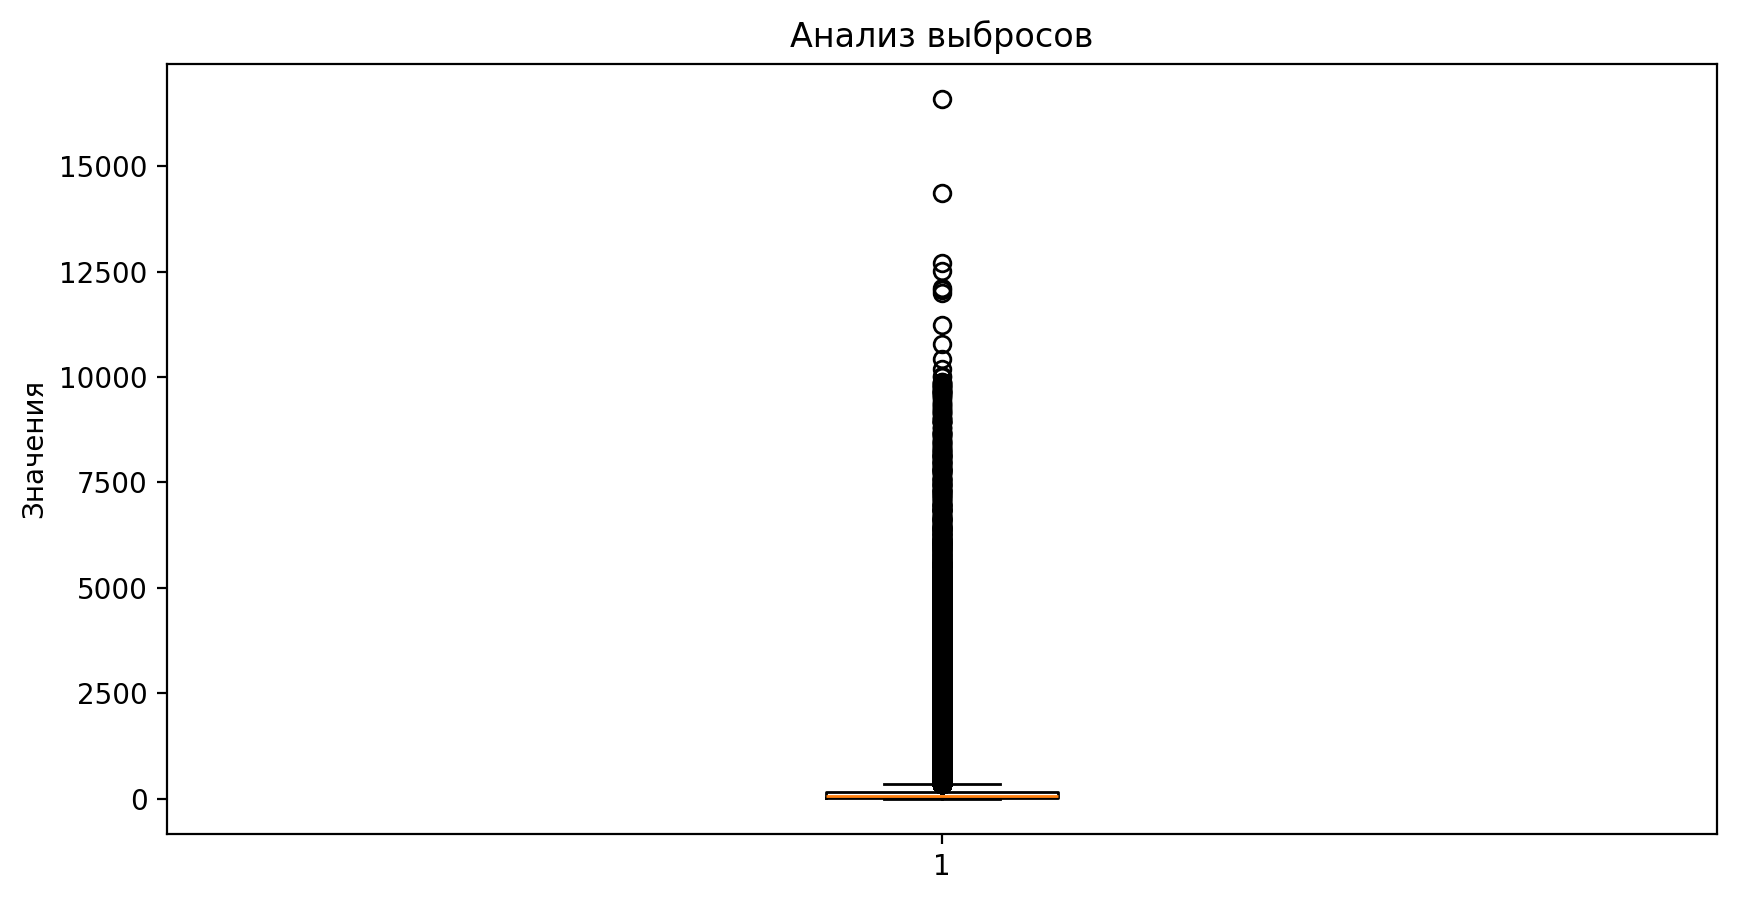

In [31]:
plt.boxplot(user_share_per_track)
plt.ylabel('Значения')
plt.title('Анализ выбросов')
plt.show()

Юзеры слушают музыку крайне неравномерно. в среднем получается 156 трек на юзера, но очевидно что есть те кто очень мало слушают, а есть кто просто обожает музыку, поэтому медианное значение - 54.

### Наиболее популярные треки

In [32]:
# Распределение количества прослушанных треков, как часто прослушивают тот или иной трек.
track_counts = interactions['track_id'].value_counts().reset_index()
track_counts.columns = ['track_id', 'listen_count']
track_counts.describe().astype('int')

,track_id,listen_count
count,932664,932664
mean,36856155,230
std,26708650,1404
min,26,5
25%,15736193,9
50%,34494959,19
75%,56726760,69
max,101521819,111062


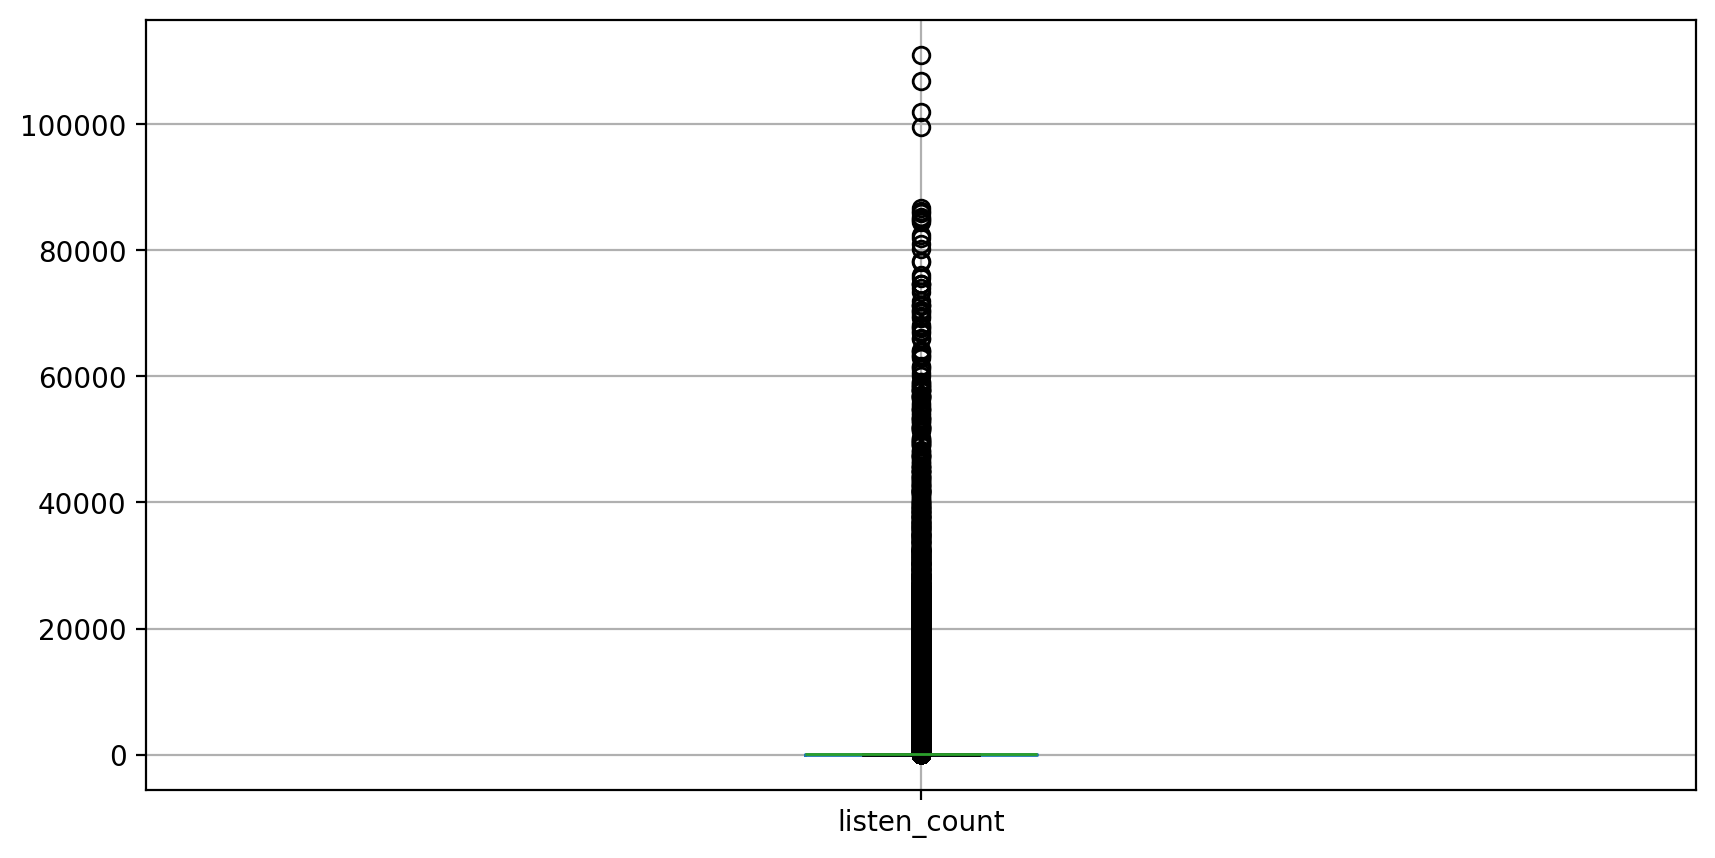

In [33]:
track_counts.boxplot(column = 'listen_count');

Text(0, 0.5, 'Количество')

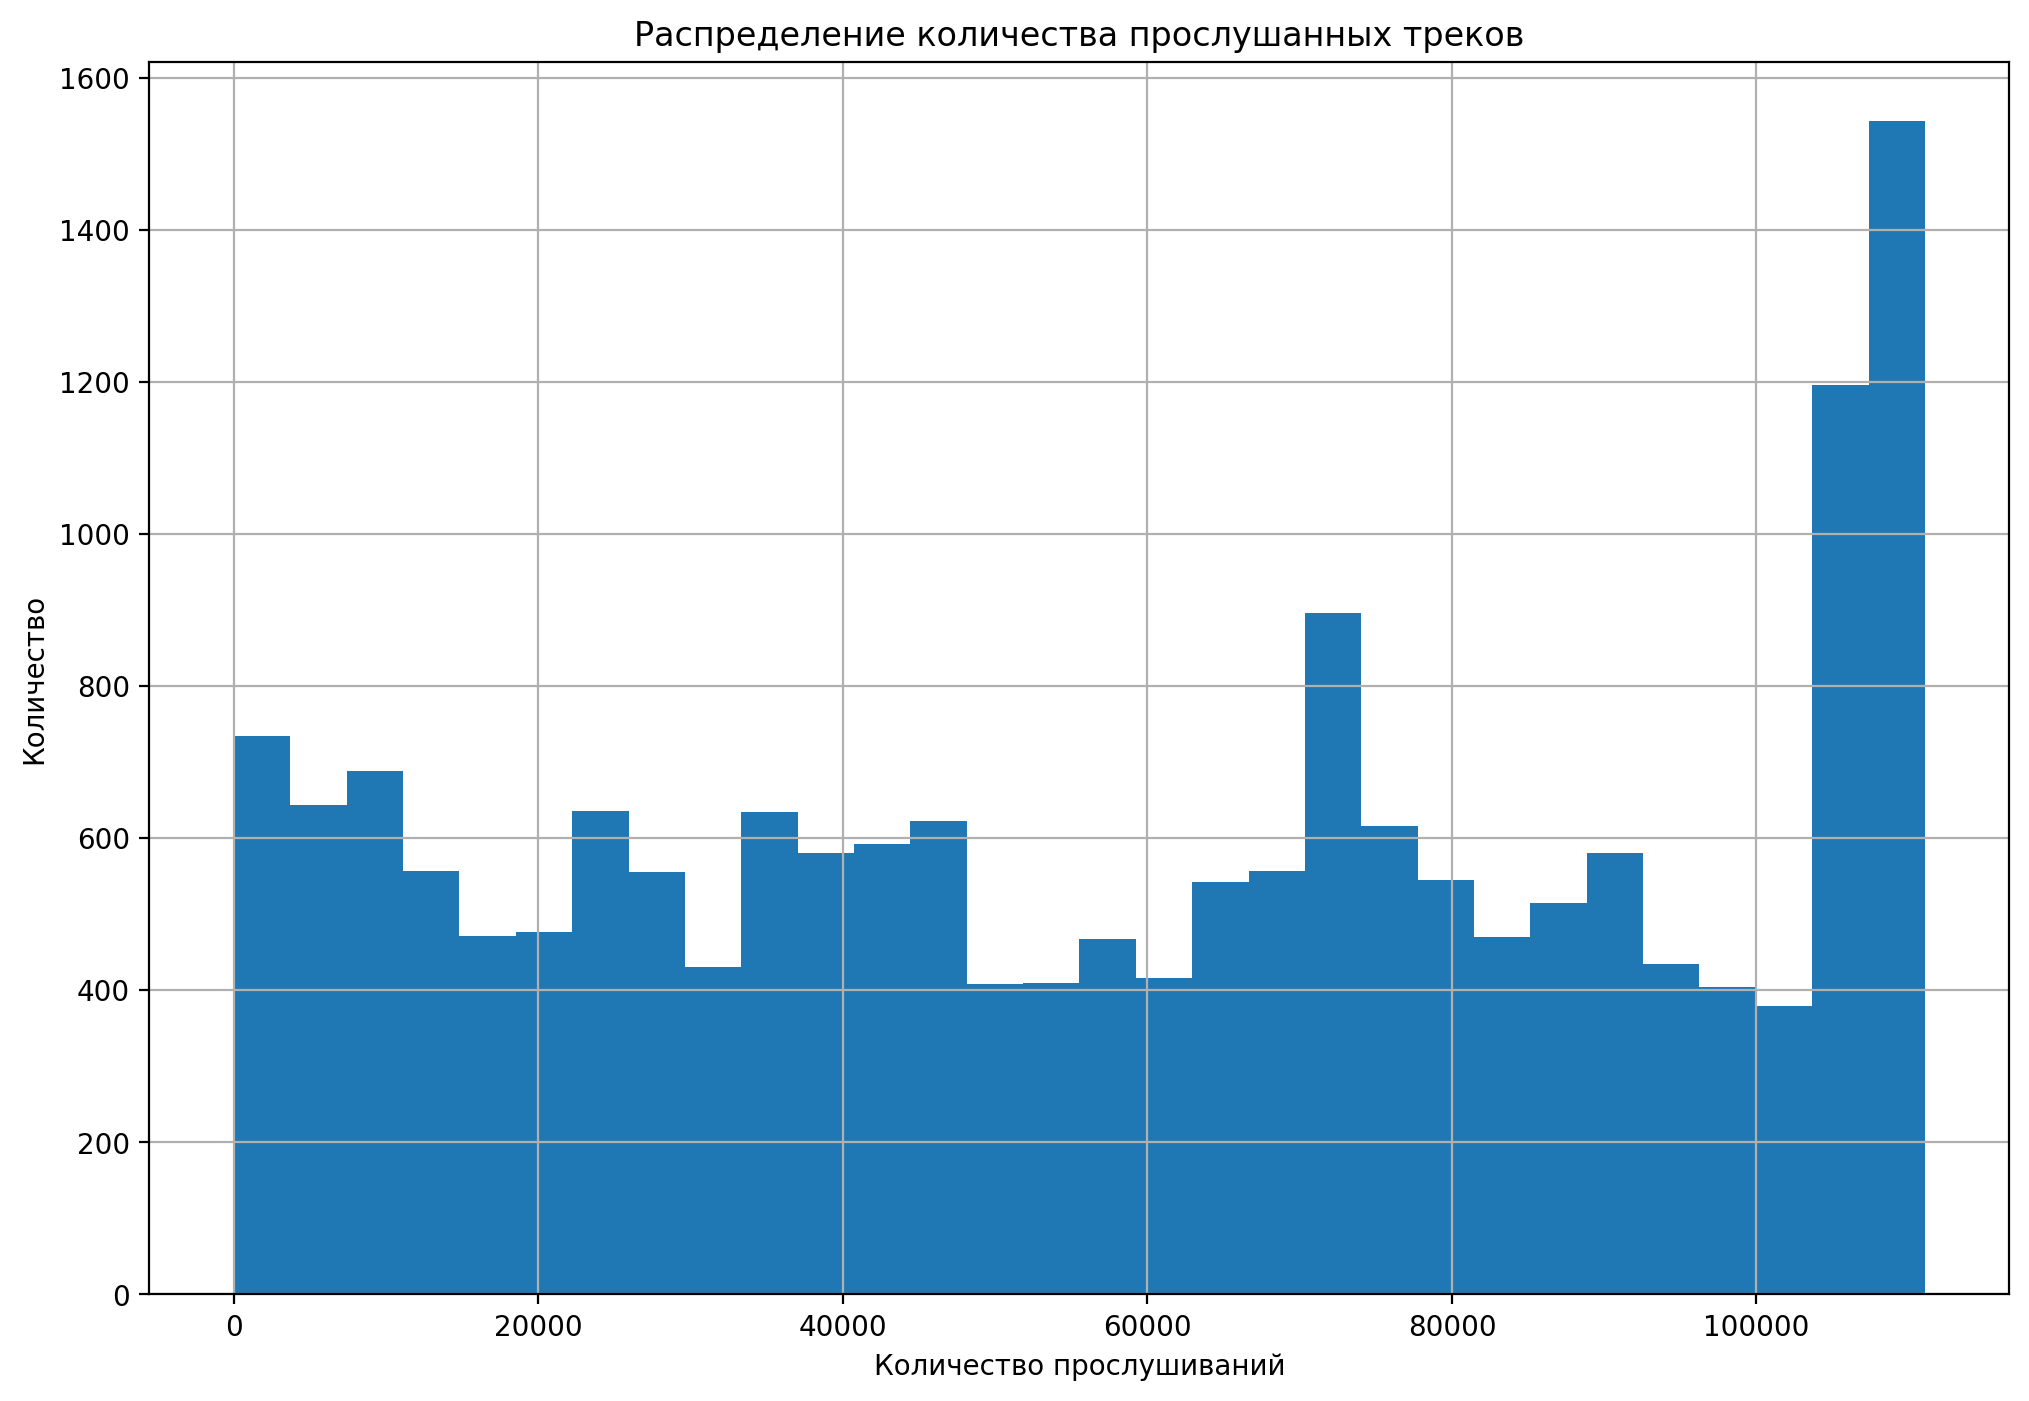

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = track_counts['track_id'].plot(kind='hist', bins=30, range=(5,111062), title='Распределение количества прослушанных треков', grid=True)
ax.set_xlabel('Количество прослушиваний')
ax.set_ylabel('Количество')

Тут очевидно тоже неравномерно, в среднем один трек прослушан 230 раз, но есть супер популярные треки, поэтому медиана 19.

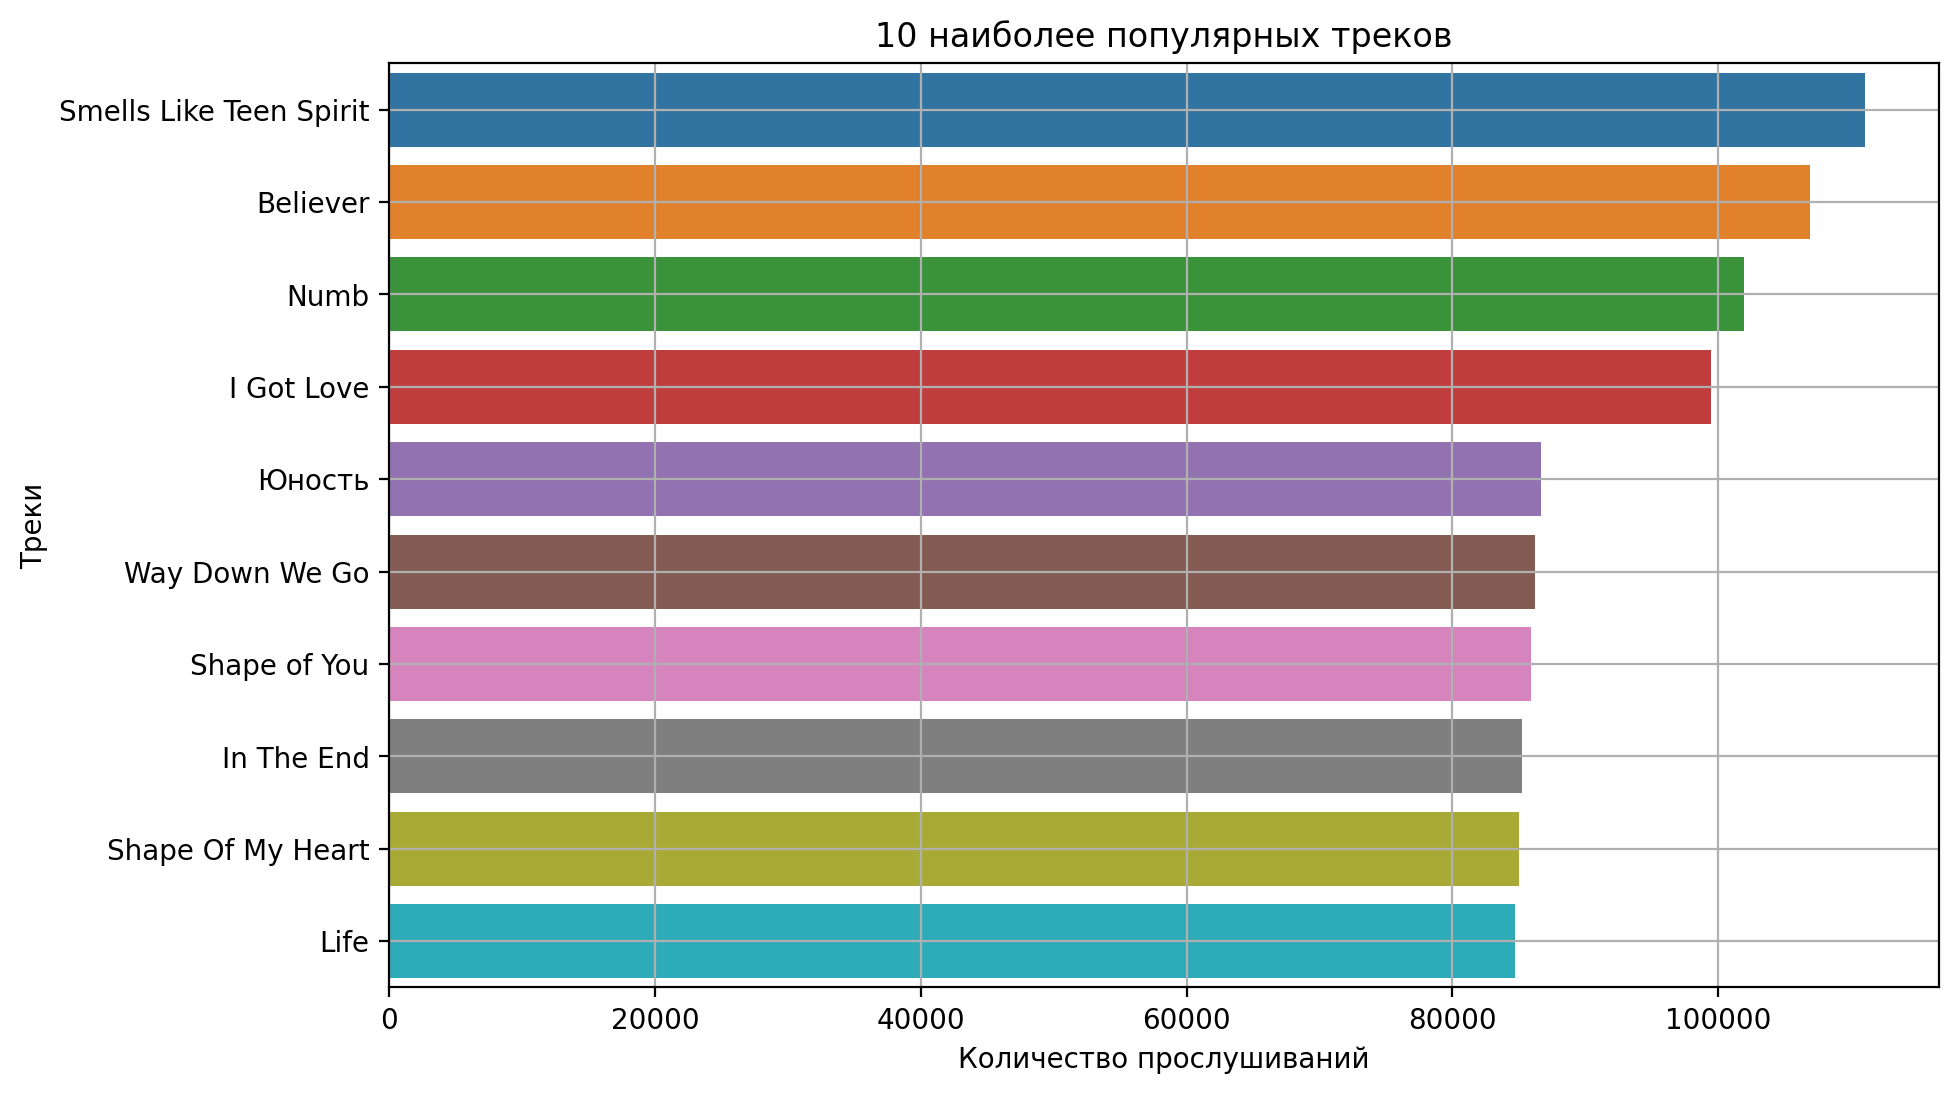

In [35]:
# объединяю с таблицей catalog_names, чтобы получить названия треков
popular_tracks = track_counts.merge(catalog_names, left_on='track_id', right_on='id', how='left')

# визуализация
plt.figure(figsize=(10, 6))
sns.barplot(data=popular_tracks.head(10), x='listen_count', y='name')
plt.title('10 наиболее популярных треков')
plt.xlabel('Количество прослушиваний')
plt.ylabel('Треки')
plt.grid()
plt.show()

### Наиболее популярные жанры

In [36]:
# объединим track_counts и interactions по track_id
merged_data = track_counts.merge(tracks, on='track_id', how='left')

In [37]:
merged_data.head()

,track_id,listen_count,albums,artists,genres
0,53404,111062,"[4367, 89708, 294911, 294912, 294914, 297393, ...",[9262],"[13, 14, 102]"
1,33311009,106921,"[4440454, 4456609, 4482682, 4882996, 5072976, ...",[675068],"[14, 102]"
2,178529,101924,"[18113, 21924, 21940, 488052, 10009799]",[36800],"[41, 47]"
3,35505245,99490,"[4431303, 20559909]","[4611844, 588511]","[3, 75]"
4,65851540,86670,[10692414],[1554548],"[11, 20]"


In [38]:
# cоздаем DataFrame для подсчета жанров
genres_count = merged_data.explode('genres')

In [39]:
# бережем машину
del track_counts
del merged_data

In [40]:
genres_count.head()

,track_id,listen_count,albums,artists,genres
0,53404,111062,"[4367, 89708, 294911, 294912, 294914, 297393, ...",[9262],13
0,53404,111062,"[4367, 89708, 294911, 294912, 294914, 297393, ...",[9262],14
0,53404,111062,"[4367, 89708, 294911, 294912, 294914, 297393, ...",[9262],102
1,33311009,106921,"[4440454, 4456609, 4482682, 4882996, 5072976, ...",[675068],14
1,33311009,106921,"[4440454, 4456609, 4482682, 4882996, 5072976, ...",[675068],102


In [41]:
# подсчитаем жанры
popular_genres = genres_count['genres'].value_counts().reset_index()
popular_genres.columns = ['genre_id', 'listen_count']

In [42]:
# создадим датафрейм с наименованиями жанров
genre_names = catalog_names.query('type == "genre"')

In [43]:
# получим названия жанров
popular_genres = pd.merge(
    popular_genres, genre_names, how='left', left_on='genre_id', right_on='id'
)

In [44]:
popular_genres.drop(['id'], axis= 1 , inplace= True )

In [45]:
popular_genres.head()

,genre_id,listen_count,type,name
0,11,166109,genre,pop
1,75,128206,genre,rap
2,102,118461,genre,allrock
3,68,106478,genre,electronics
4,3,65958,genre,rusrap


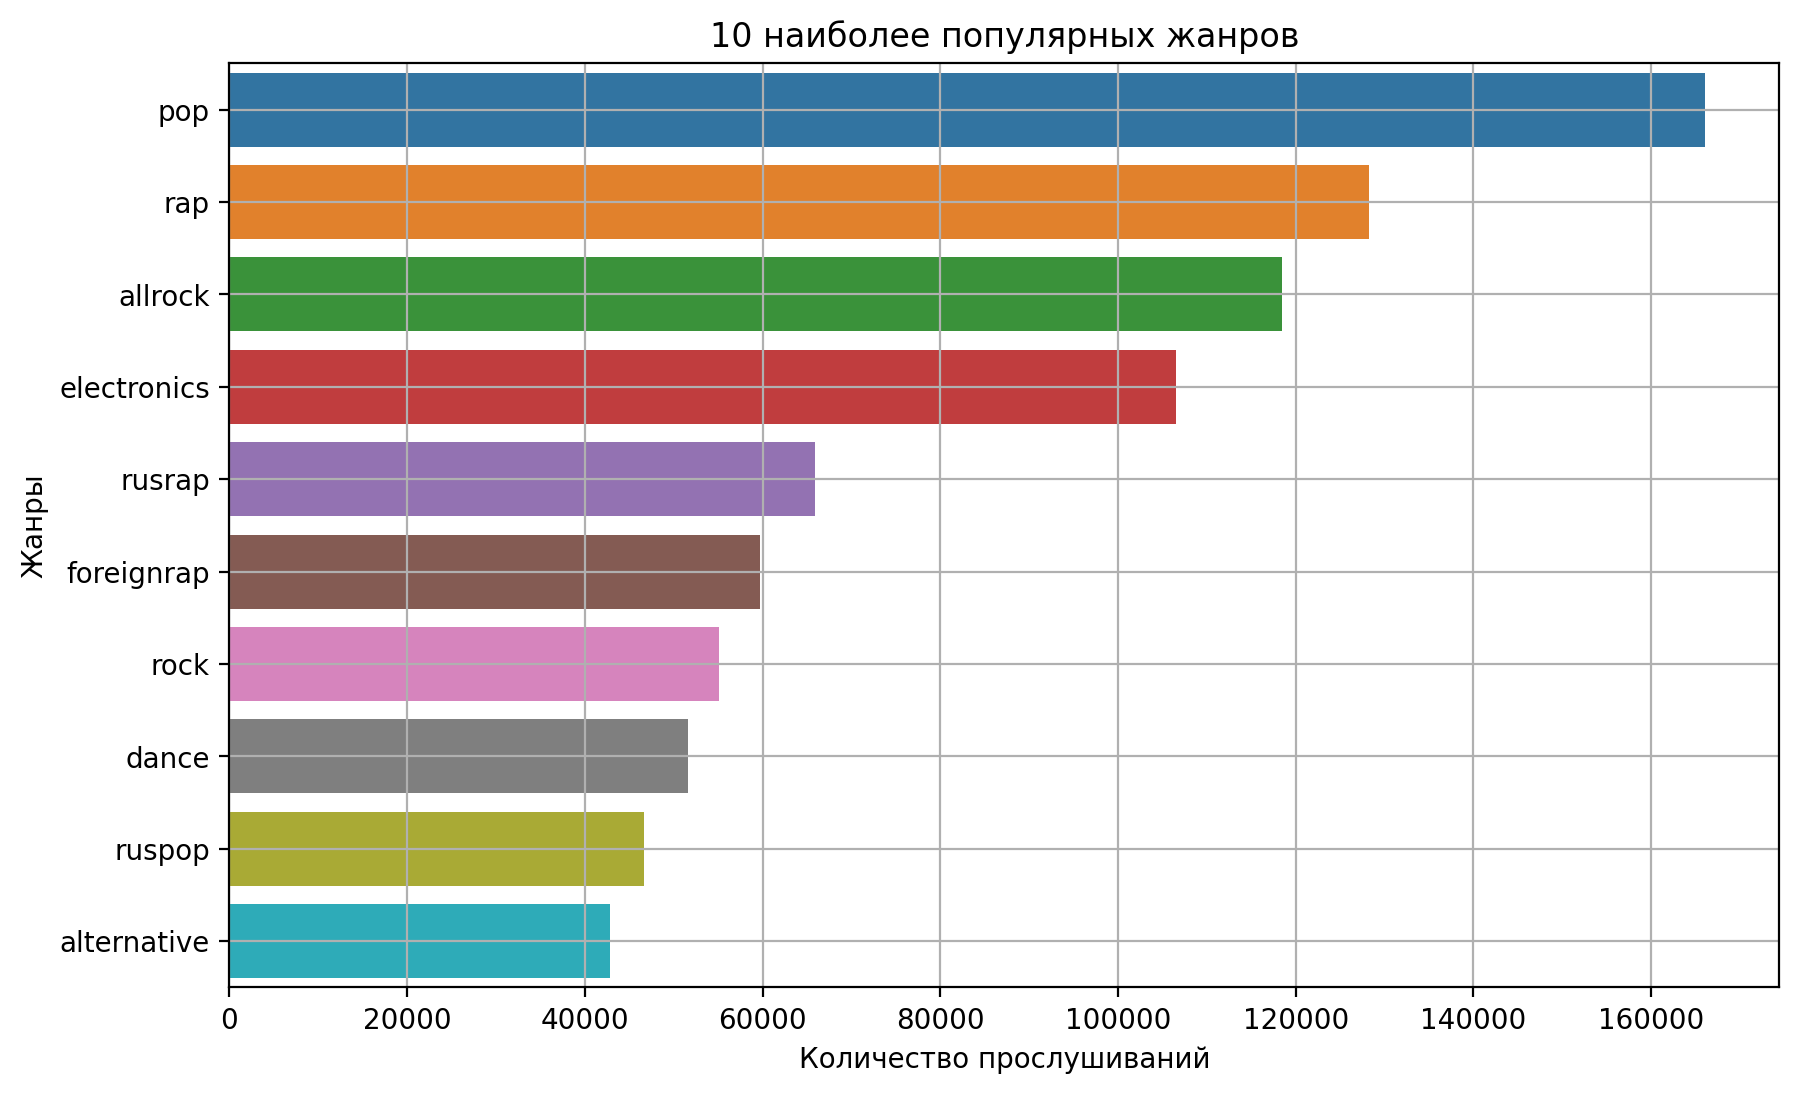

In [46]:
# визуализация
plt.figure(figsize=(10, 6))
sns.barplot(data=popular_genres.head(10), x='listen_count', y='name')
plt.title('10 наиболее популярных жанров')
plt.xlabel('Количество прослушиваний')
plt.ylabel('Жанры')
plt.grid()
plt.show()

Как то неожиданно (нет) самымым популярным оказался жанр "pop".

In [47]:
del popular_genres

### Треки, которые никто не прослушал

In [48]:
# gолучаем треки, которые не были прослушаны
unlistened_tracks = tracks[~tracks['track_id'].isin(interactions['track_id'])]

print("Треки, которые никто не прослушал:")
print(unlistened_tracks)

Треки, которые никто не прослушал:
Empty DataFrame
Columns: [track_id, albums, artists, genres]
Index: []


Честно говоря уже при подсчете количества прослушивания треков было понятно не прослушанных треков нет, минимальное количество прослушиваний трека равно 5.

# Преобразование данных

### Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

Проверю какие ресурсы тебует датафрейм tracks и пожалуй преобразую тип идентификаторов в int32 и кортеж.

In [49]:
tracks.sample(5)

,track_id,albums,artists,genres
424540,31821452,[3865332],[167049],"[19, 325]"
678382,53997809,"[7751935, 7751948]",[1545255],[13]
73874,700051,[37163],[118708],"[7, 112, 61]"
511342,37721617,[4787697],[676607],"[11, 20, 61]"
883699,84779784,"[16110192, 16809193, 16942244]","[3255421, 4294519]",[13]


In [50]:
# проверка сколько ресурсов потребляет датафрем tracks
def memory_load(df):
    memory_info = df.memory_usage(deep=True)
    total_memory = memory_info.sum()
    print("Память по столбцам:")
    print(memory_info)
    print("\nОбщее использование памяти (в байтах):", total_memory)

memory_load(tracks)

Память по столбцам:
Index             128
track_id      7461312
albums      111919680
artists     111919680
genres      111919680
dtype: int64

Общее использование памяти (в байтах): 343220480


In [51]:
# преобразование типа данных в int32 и списков в кортежи для экономии ресурсов.
tracks = tracks.reset_index(drop=True)
tracks['track_id'] = tracks['track_id'].astype('int32')
tracks[['albums', 'artists', 'genres']] = (
    tracks[['albums', 'artists', 'genres']]
    .map(lambda x: tuple(x.astype('int32')))
)

In [52]:
tracks.sample(5)

,track_id,albums,artists,genres
397596,29550086,"(3555204,)","(3043698,)","(47,)"
760374,64135059,"(10266495,)","(8955054,)","(11,)"
742119,61992170,"(9727667,)","(8656057,)","(11,)"
11615,75773,"(6660, 7100, 87888, 5026484, 5044725, 5104718,...","(3402,)","(14, 102)"
595973,44254636,"(5929268,)","(4545156,)","(3, 75)"


In [53]:
memory_load(tracks)

Память по столбцам:
Index            128
track_id     3730656
albums      68083368
artists     54416368
genres      56875568
dtype: int64

Общее использование памяти (в байтах): 183106088


Переработаю датафрейм с каталогом наименований.

In [54]:
# проверяем ресурсы которые требует каталог наименований. 
memory_load(catalog_names)

Память по столбцам:
Index          128
id        14499768
type     112526783
name     162241642
dtype: int64

Общее использование памяти (в байтах): 289268321


Весомо, преобразую строковые данные в категориальные с помощью метода класса CategoricalDtype

In [55]:
# "ужимаем" id до int32
catalog_names = catalog_names.reset_index(drop=True)
catalog_names['id'] = catalog_names['id'].astype('int32')

In [56]:
# одно из основных преимуществ категориальных типов данных - более эффективное использование памяти.
catalog_names['type'] = catalog_names['type'].astype('category')
catalog_names['name'] = catalog_names['name'].astype('category')

In [57]:
memory_load(catalog_names)

Память по столбцам:
Index          128
id         7249884
type       1812892
name     130221242
dtype: int64

Общее использование памяти (в байтах): 139284146


In [58]:
catalog_names.sample(5)

,id,type,name
1734388,79142059,track,Тебе это нравится
1136287,20965367,track,"Hello, Dolly! (From the Musical Production, ""H..."
1028231,9753042,track,Dum Dum
242970,3789605,album,Country Pop
217387,3305526,album,"Sweet & Sexy (20 Amazing Lounge Anthems), Vol. 4"


Уже сейчас возможно добавить из каталога наименований названия треков в датафрейм с треками.

In [59]:
# добавление наименование трека
tracks = tracks.merge(
    catalog_names.query('type == "track"')[['id', 'name']],
    left_on='track_id',
    right_on='id',
    how='left'
).drop(columns=['id'])

tracks.head(3)

,track_id,albums,artists,genres,name
0,26,"(3, 2490753)","(16,)","(11, 21)",Complimentary Me
1,38,"(3, 2490753)","(16,)","(11, 21)",Momma's Boy
2,135,"(12, 214, 2490809)","(84,)","(11,)",Atticus


Если наименования жанров, альбомов и исполнителей  из каталога наименований добавить к датафрейму с треками, получится один полный датафрейм. Соответсвенно задача выглядит как преобразование датафрейма в словари с id и наименованием к чему этот id относится.

In [60]:
# создание словарей {id:name} aplbum, artist, genre.
albums_names = catalog_names[catalog_names['type'] == 'album'].set_index('id')['name'].to_dict()
artists_names = catalog_names[catalog_names['type'] == 'artist'].set_index('id')['name'].to_dict()
genres_names = catalog_names[catalog_names['type'] == 'genre'].set_index('id')['name'].to_dict()

In [61]:
# лямбда для формирования кортежей с наименованиями на основе кортежей с ids
func_albums_names = lambda x: tuple(map(albums_names.__getitem__, x))
func_artists_names = lambda x: tuple(map(artists_names.__getitem__, x))
func_genres_names = lambda x: tuple(map(genres_names.__getitem__, x))

In [62]:
tracks['names_of_albums_'] = tracks['albums'].map(func_albums_names)
tracks['names_of_artists'] = tracks['artists'].map(func_artists_names)
tracks['names_of_genres'] = tracks['genres'].map(func_genres_names)

In [63]:
tracks.head()

,track_id,albums,artists,genres,name,names_of_albums_,names_of_artists,names_of_genres
0,26,"(3, 2490753)","(16,)","(11, 21)",Complimentary Me,"(Taller Children, Taller Children)","(Elizabeth & the Catapult,)","(pop, folk)"
1,38,"(3, 2490753)","(16,)","(11, 21)",Momma's Boy,"(Taller Children, Taller Children)","(Elizabeth & the Catapult,)","(pop, folk)"
2,135,"(12, 214, 2490809)","(84,)","(11,)",Atticus,"(Wild Young Hearts, Wild Young Hearts, Wild Yo...","(Noisettes,)","(pop,)"
3,136,"(12, 214, 2490809)","(84,)","(11,)",24 Hours,"(Wild Young Hearts, Wild Young Hearts, Wild Yo...","(Noisettes,)","(pop,)"
4,138,"(12, 214, 322, 72275, 72292, 91199, 213505, 24...","(84,)","(11,)",Don't Upset The Rhythm (Go Baby Go),"(Wild Young Hearts, Wild Young Hearts, Don't U...","(Noisettes,)","(pop,)"


In [ ]:
del albums_names
del artists_names
del genres_names 

In [ ]:
interactions весьма объемный датафрейм, но типы данных там уже компактны, посмотрим что возможно с ним еще сделать.

In [71]:
interactions.sample(5)

,user_id,track_id,track_seq,started_at
19,1000882,45499814,20,2022-11-02
19,1224014,25829288,20,2022-04-11
1180,616929,42477658,1181,2022-11-13
221,1003727,35261802,222,2022-07-05
71,209589,32182642,72,2022-10-31


In [69]:
#interactions.info()

In [67]:
memory_load(interactions)

Память по столбцам:
Index         1717765904
user_id        858882952
track_id       858882952
track_seq      429441476
started_at    1717765904
dtype: int64

Общее использование памяти (в байтах): 5582739188


Проверю с какой частотой фиксируются события. Какова дискретность.

In [85]:
events_per_user = interactions.groupby('started_at').agg(
    {'user_id': ['count', 'nunique']}
)
events_per_user.head()

user_id        
             count nunique
started_at                
2022-01-01   33979    5731
2022-01-02   35211    7049
2022-01-03   38007    8201
2022-01-04   41041    9240
2022-01-05   44169   10680

Похоже что события фиксируются по дневно. 

In [86]:
del events_per_user

In [87]:
# еще одна проверка
interactions['started_at'].drop_duplicates().sort_values().diff().min()

Timedelta('1 days 00:00:00')

Так и есть, дискретность один день. Повод для категоризации этих значений.

In [88]:
interactions = interactions.reset_index(drop=True)
interactions['started_at'] = interactions['started_at'].astype('category')

In [89]:
memory_load(interactions)

Память по столбцам:
Index               128
user_id       858882952
track_id      858882952
track_seq     429441476
started_at    429452692
dtype: int64

Общее использование памяти (в байтах): 2576660200


Есть экономия!

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [90]:
# создаем датафреймы events и items
items = tracks.copy()
events = interactions.copy()

In [98]:
del tracks
del catalog_names
del interactions

In [95]:
#items.head()
#events.head()

In [96]:
# сохранение результатов
items.to_parquet('datasets/items.parquet')

In [97]:
events.to_parquet('datasets/events.parquet')

Загрузка файлов в бакеты.

In [121]:
upload_to_yandex_s3('datasets/items.parquet', 'recsys/data/items.parquet')

Файл успешно загружен в бакет s3-student-mle-20240325-db8a481ea6.


In [122]:
upload_to_yandex_s3('datasets/events.parquet', 'recsys/data/events.parquet')

Файл успешно загружен в бакет s3-student-mle-20240325-db8a481ea6.


# Очистка памяти

Удаляю переменные и перезапускаю ядро в интерфейсе notebook для работы с дальнейшим этапом который потребует ресурсных вычислений.

In [124]:
del items
del events

# === ЭТАП 3 ===

# Загрузка данных

In [1]:
# загрузка необходимых библиотек.
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tqdm as notebook_tqdm
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import LabelEncoder

from services.load_s3 import upload_to_yandex_s3

/home/mle-user/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pickle

In [3]:
items = pd.read_parquet('datasets/items.parquet')
events = pd.read_parquet('datasets/events.parquet')

In [4]:
#items.head()

In [5]:
# устраняю ошибку по наименованию столбца
items = items.rename(columns={'names_of_albums_': 'names_of_albums'})

In [6]:
# несколько модернизирую функцию для оценки потребления ресурсов
def memory_load(df):
    memory_info = df.memory_usage(deep=True)
    total_memory = memory_info.sum()
    
    # Преобразование из байт в мегабайты
    total_memory_mb = total_memory / (1024 ** 2)
    
    print("Память по столбцам:")
    print(memory_info)
    print("\nОбщее использование памяти (в мегабайтах):",total_memory_mb.round(2))


memory_load(items)

Память по столбцам:
Index                     128
track_id              3730656
albums              111919680
artists             111919680
genres              111919680
name                118964639
names_of_albums     111919680
names_of_artists    111919680
names_of_genres     111919680
dtype: int64

Общее использование памяти (в мегабайтах): 757.42


In [7]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932664 entries, 0 to 932663
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   track_id          932664 non-null  int32   
 1   albums            932664 non-null  object  
 2   artists           932664 non-null  object  
 3   genres            932664 non-null  object  
 4   name              932664 non-null  category
 5   names_of_albums   932664 non-null  object  
 6   names_of_artists  932664 non-null  object  
 7   names_of_genres   932664 non-null  object  
dtypes: category(1), int32(1), object(6)
memory usage: 89.3+ MB


Опять вижу в данных массивы, почему то не сохранилось "закортеживание". Повторяю.

In [8]:
items[['albums', 'artists', 'genres','names_of_albums', 'names_of_artists', 'names_of_genres']] = (
    items[['albums', 'artists', 'genres','names_of_albums', 'names_of_artists', 'names_of_genres']]
    .map(lambda x: tuple(x))
)

In [9]:
memory_load(items)

Память по столбцам:
Index                     128
track_id              3730656
albums               68083368
artists              54416368
genres               56875568
name                118964639
names_of_albums      68083368
names_of_artists     54416368
names_of_genres      56875568
dtype: int64

Общее использование памяти (в мегабайтах): 459.14


In [10]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214720738 entries, 0 to 214720737
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 3.6 GB


In [11]:
memory_load(events)

Память по столбцам:
Index                128
user_id        858882952
track_id       858882952
track_seq      429441476
started_at    1717765904
dtype: int64

Общее использование памяти (в мегабайтах): 3685.93


In [12]:
# категоризируем started_at и упорядочим для возможности сравнения с временными метками.
events = events.reset_index(drop=True)
events['started_at'] = events['started_at'].astype('category').cat.as_ordered()

In [13]:
memory_load(events)

Память по столбцам:
Index               128
user_id       858882952
track_id      858882952
track_seq     429441476
started_at    429452692
dtype: int64

Общее использование памяти (в мегабайтах): 2457.29


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки. В тренировочную отношу все данные до 16 декабря 2022 года (не включительно).

In [14]:
# зададим точку разбиения
train_test_global_time_split = (events['started_at'] < pd.to_datetime('2022-12-16'))

events_train = events[train_test_global_time_split]
events_test = events[~train_test_global_time_split]

In [15]:
# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates() 
# количество пользователей, которые есть и в train, и в test
common_users = users_train[users_train.isin(users_test)] 

print(len(users_train), len(users_test), len(common_users)) 

1341269 778789 748016


In [16]:
# посчитаем количество "холодных" пользователей.
cold_users =  users_test[~users_test.isin(users_train)]# ваш код здесь #
print(len(cold_users)) 

30773


In [17]:
del train_test_global_time_split, users_test, users_train, cold_users

# Топ популярных

Рассчитаем рекомендации как топ популярных. Для этого посчитаем количество прослушиваний каждого трека, для удобства нормализируем количетво в оценки "score". Выделим топ-25 (для облегчения данных) и сохраним в соответсвующем файле.

In [18]:
events_train.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [23]:
# посчитаем количество прослушиваний треков.
popular_tracks = events_train.groupby('track_id').size().reset_index(name='play_count')
popular_tracks = popular_tracks.sort_values(by='play_count', ascending=False, ignore_index=True)
popular_tracks.head()

,track_id,play_count
0,53404,110026
1,33311009,101076
2,178529,100866
3,35505245,95523
4,24692821,84153


In [24]:
# нормализируем количество прослушивания с помощью min max нормализации.
min_play_count = popular_tracks['play_count'].min()
max_play_count = popular_tracks['play_count'].max()

popular_tracks['score'] = ((popular_tracks['play_count'] - min_play_count) / 
                            (max_play_count - min_play_count)).round(2)
del popular_tracks['play_count']

In [25]:
top_popular = popular_tracks.head(50)
top_popular.head()

,track_id,score
0,53404,1.00
1,33311009,0.92
2,178529,0.92
3,35505245,0.87
4,24692821,0.76


In [82]:
# Сохраняем локально
top_popular.to_parquet('datasets/top_popular.parquet')

In [26]:
del popular_tracks, min_play_count, max_play_count

In [32]:
recom_top = (
    events_test[['user_id']]
    .drop_duplicates()
    .reset_index(drop=True)
    .merge(top_popular, how='cross')
    .reset_index(drop=True)
)
recom_top.head(3)

,user_id,track_id,score
0,3,53404,1.00
1,3,33311009,0.92
2,3,178529,0.92


In [26]:
recom_top.to_parquet('datasets/recom_top.parquet')

In [35]:
upload_to_yandex_s3('datasets/recom_top.parquet', 'recsys/recommendations/top_popular.parquet')

Файл успешно загружен в бакет s3-student-mle-20240325-db8a481ea6.


In [56]:
def precision_recall_metrics(events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """
    # отмечаем события 'ground truth'
    events_test["gt"] = True
    
    common_users = (
        set(events_test["user_id"].drop_duplicates())
        & set(recs["user_id"].drop_duplicates())
    )
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # в теории мы оставляли только те item_id, которые были в events_train, но в данном случаем нет уверенности что  так нужно делать.
    
    #events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    # выбираем только top_k рекомендаций для юзера
    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
        
    # объеденяем тестовую выборку и рекомендации
    events_recs_common = events_for_common_users[["user_id", "track_id", "gt"]].merge(
        recs_for_common_users[["user_id", "track_id", "score"]], 
        on=["user_id", "track_id"], how="outer"
    )    
    
    # помечаем нерелевантные'ground truth'
    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)

    # если есть score отмечаем событие как 'pr'
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    groupper = events_recs_common.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    precision = round(precision, 4)*100
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum() / (groupper["tp"].sum() + groupper["fn"].sum())
    recall = recall.fillna(0).mean()
    recall = round(recall, 4)*100

    return precision, recall

In [57]:
#precision_recall_metrics(events_test, recom_top, 5)

In [58]:
def coverage_metric(recs, items):
    """
    расчитывает покрытие рекомендациями по объектам
    """
    get_item_coverage = recs['track_id'].nunique() / len(items)
    get_item_coverage = round(get_item_coverage, 4)*100
    
    return get_item_coverage

In [59]:
#coverage_metric(recom_top, items)

In [60]:
def novelty_metric(recs, events_train, top_k):
    """
    Расчет вероятности предложения пользователю объекты, которые он ранее не видел.
    Novelty@k = ∣recommended@k∣ / ∣unknown@k∣
    """
    # оставляем tok_k рекомендаций.
    top_recs = (
        recs
        .sort_values(by=['user_id', 'score'], ascending=[True, False],
                     ignore_index=True)
        .groupby('user_id')
        .head(top_k)
        .reset_index(drop=True)
        .copy()
    )

    # оставляем пользователей и треки которые присутствуют в топе рекомендаций
    events_train = (
        events_train[
            events_train['user_id'].isin(top_recs['user_id'])
            & events_train['track_id'].isin(top_recs['track_id'])
        ]
        [['user_id', 'track_id']]
        .reset_index(drop=True)
        .copy()
    )

    # разметим каждую события признаком unknown
    events_train['unknown'] = False

    # добавим  'unknown' к таблице рекомендаций
    top_recs = top_recs.merge(
        events_train[['user_id', 'track_id', 'unknown']],
        on=['user_id', 'track_id'],
        how='left'
    )
    top_recs['unknown'] = top_recs['unknown'].fillna(True).astype('bool')
    novelty = top_recs.groupby('user_id')['unknown'].mean().mean() 
    novelty = round(novelty, 4)*100

    return novelty

In [61]:
#novelty_metric(recom_top, events_train, 5)

In [62]:
def combined_metrics(
  recs,
  items, 
  events_train,
  events_test,
  top_k):
    """
    Комбинирует метрики покрытия и новизны в один DataFrame.
    
    :param recks: DataFrame рекомендаций
    :param items: DataFrame с объектами
    :param events_train: DataFrame с прошлым событиями
    :param top_k: количество верхних рекомендаций
    :return: DataFrame с метриками
    """
    precision, recall = precision_recall_metrics(events_test, recs, top_k)
    coverage = coverage_metric(recs, items)
    novelty = novelty_metric(recs, events_train, top_k)
    
    
    metrics_df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'Coverage', 'Novelty'],
        'Value': [precision, recall, coverage, novelty]
    })

    return metrics_df

In [33]:
top_pop_metrics = combined_metrics(recom_top, items, events_train, events_test, 5)
top_pop_metrics

/tmp/ipykernel_1862/2107217775.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True


,Metric,Value
0,Precision,0.36
1,Recall,0.13
2,Coverage,0.01
3,Novelty,92.62


In [34]:
top_pop_metrics.to_parquet('datasets/top_pop_metrics.parquet')

In [37]:
del recom_top, top_pop_metrics

Метрики кроме Novelty весьма низкие, но это не сюрприз, вполне логичная история.

# Персональные

Рассчитаем персональные рекомендации.

In [19]:
import scipy
import sklearn.preprocessing

# перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

# перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["track_id"])
items["track_id_enc"] = item_encoder.transform(items["track_id"])
events_train["track_id_enc"] = item_encoder.transform(events_train["track_id"])
events_test["track_id_enc"] = item_encoder.transform(events_test["track_id"])

/tmp/ipykernel_2015/1913820112.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
/tmp/ipykernel_2015/1913820112.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])
/tmp/ipykernel_2015/1913820112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [39]:
# проверим макимальное значение для events_train['track_id_enc']
events_train['track_id_enc'].max()

932663

In [40]:
# визуальная проверка
events_train.sample(5)

,user_id,track_id,track_seq,started_at,user_id_enc,track_id_enc
81028817,519577,19736482,71,2022-04-13,518640,281654
188737887,1208620,565378,16,2022-10-25,1206393,53968
128704344,824256,55568,28,2022-05-24,822713,8451
80718919,517530,80048341,116,2022-09-22,516595,864915
119375533,764504,48592379,1137,2022-11-02,763093,630334


Для получения разряженной матрицы, четко обозначим что прогнозируем в рекомендациях. В имеющемся наборе данных, можно установить место трека в истории прослушивания, что возможно может помочь сделать некую ограниченную выборку, но скорее не поможет при прогнозировании. В наборе присутствует дата взаимодействия пользователя с треком, поэтому представм что наша матрица будет вида "лайкнул" трек или нет. 

In [20]:
user_item_matrix_train = scipy.sparse.csr_matrix((
    np.ones(len(events_train)),
    (events_train['user_id_enc'], events_train['track_id_enc'])),
    dtype=np.int8)

In [21]:
print("Shape of user-item matrix (CSR):", user_item_matrix_train.shape)

Shape of user-item matrix (CSR): (1372042, 932664)


In [22]:
import sys

sum([sys.getsizeof(i) for i in user_item_matrix_train.data])/1024**3 

4.684656392782927

In [44]:
als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train) 

/home/mle-user/.local/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 50/50 [40:18<00:00, 48.36s/it]


In [45]:
als_model

In [100]:
with open('models/als_model.pkl', 'wb') as f:
       pickle.dump(als_model, f)


In [23]:
with open('models/als_model.pkl', 'rb') as f:
    als_model = pickle.load(f)

In [24]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"track_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["track_id"] = item_encoder.inverse_transform(recommendations["track_id_enc"])
    
    return recommendations

In [25]:
# выберем произвольного пользователя из тренировочной выборки ("прошлого")
user_id = events_train['user_id'].sample().iat[0]

print(f"user_id: {user_id}")

user_id: 174845


In [26]:
get_recommendations_als(user_item_matrix_train, als_model, user_id, user_encoder, item_encoder)

,track_id_enc,score,track_id
0,112104,1.325974,2192826
1,53626,1.279978,560468
2,397911,1.226237,29569939
3,397551,1.222074,29544272
4,27994,1.219311,234701


In [27]:
items.head()

,track_id,albums,artists,genres,name,names_of_albums,names_of_artists,names_of_genres,track_id_enc
0,26,"(3, 2490753)","(16,)","(11, 21)",Complimentary Me,"(Taller Children, Taller Children)","(Elizabeth & the Catapult,)","(pop, folk)",0
1,38,"(3, 2490753)","(16,)","(11, 21)",Momma's Boy,"(Taller Children, Taller Children)","(Elizabeth & the Catapult,)","(pop, folk)",1
2,135,"(12, 214, 2490809)","(84,)","(11,)",Atticus,"(Wild Young Hearts, Wild Young Hearts, Wild Yo...","(Noisettes,)","(pop,)",2
3,136,"(12, 214, 2490809)","(84,)","(11,)",24 Hours,"(Wild Young Hearts, Wild Young Hearts, Wild Yo...","(Noisettes,)","(pop,)",3
4,138,"(12, 214, 322, 72275, 72292, 91199, 213505, 24...","(84,)","(11,)",Don't Upset The Rhythm (Go Baby Go),"(Wild Young Hearts, Wild Young Hearts, Don't U...","(Noisettes,)","(pop,)",4


In [28]:
print("История (последние события, recent)")
user_history = (
    events_train
    .query("user_id == @user_id")
    .merge(items.set_index("track_id")[["name", "names_of_artists", "names_of_albums", "names_of_genres"]], on="track_id")
)

user_history_to_print = user_history[["name", "names_of_artists", "names_of_albums", "names_of_genres"]].tail(10)
display(user_history_to_print)

print("Рекомендации")
user_recommendations = get_recommendations_als(user_item_matrix_train, als_model, user_id, user_encoder, item_encoder)
user_recommendations = user_recommendations.merge(items[["track_id", "name", "names_of_artists", "names_of_albums", "names_of_genres"]], on="track_id" )
display(user_recommendations) 

История (последние события, recent)


,name,names_of_artists,names_of_albums,names_of_genres
2877,Kill Me Slow,"(David Guetta, MORTEN)","(New Rave,)","(dance,)"
2878,Хоровод,"(СерьГа,)","(Чистота,)","(rusrock, allrock)"
2879,"Там, где далеко","(СерьГа,)","(Чистота,)","(rusrock, allrock)"
2880,неболей,"(Zivert, Баста)","(неболей,)","(pop, ruspop)"
2881,Nothing Else Matters,"(Metallica, San Francisco Symphony)","(Nothing Else Matters,)","(rock, allrock)"
2882,Now That I've Found U,"(Low Deep T,)","(Now That I've Found U,)","(electronics, house)"
2883,Big In Japan,"(Alex Midi,)","(Personal Computer Music,)","(dance,)"
2884,Te Quiero Baby (I Love You Baby),"(Chesca, Pitbull, Frankie Valli)","(Te Quiero Baby (I Love You Baby), Quiero Ritm...","(pop,)"
2885,Лето без Интернета,"(Мумий Тролль,)","(Best 20-20, ПОСЛЕ ЗЛА)","(rusrock, allrock)"
2886,Жимолость,"(Мумий Тролль,)","(Best 20-20,)","(rusrock, allrock)"


Рекомендации


,track_id_enc,score,track_id,name,names_of_artists,names_of_albums,names_of_genres
0,112104,1.325974,2192826,Владивосток 2000,"(Мумий Тролль,)","(Морская, Best 20-20)","(rusrock, allrock)"
1,53626,1.279978,560468,Варвара,"(Би-2,)","(Би-2,)","(rusrock, allrock)"
2,397911,1.226237,29569939,Tuesday,"(Burak Yeter, Danelle Sandoval)","(Tuesday, Танцевальный рай 37, Hit List 2016, ...","(dance,)"
3,397551,1.222074,29544272,Human,"(Rag'n'Bone Man,)","(Human, Human, Some Chillout Music, Music Made...","(soundtrack, indie)"
4,27994,1.219311,234701,U Can't Touch This,"(MC Hammer,)",(Hip To The Hop: 30th Anniversary Of Hip Hop H...,"(films, soundtrack, foreignrap, rap)"


In [29]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

In [30]:
# получаем рекомендации для всех пользователей
personal_als = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=True, N=10)

In [31]:
# преобразуем полученные рекомендации в табличный формат
track_ids_enc = personal_als[0]
als_scores = personal_als[1]

personal_als = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "track_id_enc": track_ids_enc.tolist(), 
    "score": als_scores.tolist()})
personal_als = personal_als.explode(["track_id_enc", "score"], ignore_index=True)

In [32]:
# приводим типы данных
personal_als["track_id_enc"] = personal_als["track_id_enc"].astype("int")
personal_als["score"] = personal_als["score"].astype("float")

# получаем изначальные идентификаторы
personal_als["user_id"] = user_encoder.inverse_transform(personal_als["user_id_enc"])
personal_als["track_id"] = item_encoder.inverse_transform(personal_als["track_id_enc"])
personal_als = personal_als.drop(columns=["user_id_enc", "track_id_enc"])

In [37]:
personal_als_metrics=combined_metrics(personal_als, items, events_train, events_test, 5)
personal_als_metrics

/tmp/ipykernel_2015/2107217775.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True


,Metric,Value
0,Precision,1.33
1,Recall,0.98
2,Coverage,0.41
3,Novelty,100.00


Метрики подросли, немного беспокоит Coverage, возможно поработать над параметрами рекомендаций и обучения, но машина с трудом справляется с текущими вычислениями.

In [38]:
personal_als_metrics.to_parquet('datasets/personal_als_metrics.parquet')

In [44]:
personal_als = personal_als[["user_id", "track_id", "score"]]
personal_als.to_parquet("datasets/personal_als.parquet") 

In [7]:
upload_to_yandex_s3('datasets/personal_als.parquet', 'recsys/recommendations/personal_als.parquet')

Файл успешно загружен в бакет s3-student-mle-20240325-db8a481ea6.


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [45]:
# получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = events_train['track_id_enc'].unique()

In [46]:
max_similar_items = 10
# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

In [47]:
# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "track_id_enc": train_item_ids_enc,
    "sim_track_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()})
similar_items = similar_items.explode(["sim_track_id_enc", "score"], ignore_index=True)

In [48]:
# приводим типы данных
similar_items["sim_track_id_enc"] = similar_items["sim_track_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

# получаем изначальные идентификаторы
similar_items["track_id_1"] = item_encoder.inverse_transform(similar_items["track_id_enc"])
similar_items["track_id_2"] = item_encoder.inverse_transform(similar_items["sim_track_id_enc"])
similar_items = similar_items.drop(columns=["track_id_enc", "sim_track_id_enc"])

# убираем пары с одинаковыми объектами
similar_items = similar_items.query("track_id_1 != track_id_2")

In [49]:
similar_items.head()

,score,track_id_1,track_id_2
1,0.937059,99262,99245
2,0.916971,99262,99254
3,0.916347,99262,99257
4,0.908396,99262,99241
5,0.903743,99262,99247


In [50]:
similar_items.to_parquet("datasets/similar.parquet") 

In [23]:
upload_to_yandex_s3('datasets/similar.parquet', 'recsys/recommendations/similar.parquet')

Файл успешно загружен в бакет s3-student-mle-20240325-db8a481ea6.


# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [18]:
min_date = events_train['started_at'].min()
max_date = events_train['started_at'].max()

print(f"Минимальная дата: {min_date}, Максимальная дата: {max_date}")

Минимальная дата: 2022-01-01 00:00:00, Максимальная дата: 2022-12-15 00:00:00


In [19]:
min_date = events_test['started_at'].min()
max_date = events_test['started_at'].max()

print(f"Минимальная дата: {min_date}, Максимальная дата: {max_date}")

Минимальная дата: 2022-12-16 00:00:00, Максимальная дата: 2022-12-31 00:00:00


В двухстадийном подходе на одних и тех же данных обучаются и выдают рекомендации как базовые модели, так и ранжирующая. Есть определенные сомнения в том чтобы использовать в качестве обучающей выборки (делить) event_test, использование этой выборки для обучения может привести к переобучению, так как модель будет "видеть" результаты, которые она не должна знать на этапе обучения. Соответственно делить предпочту имеющуюся event_train. Это позволит оценить производительность модели в реальных сценариях, а также гарантирует, что модель сможет обрабатывать данные, которые она никогда не видела ранее.

Данные в обучающей выборке у нас за год, с 1 января 2022 по 15 декабря 2022, для ранжирующей модели возьму период в 20 дней, с 25 ноября 2022 по 15 декабря 2022.

In [18]:
split_date = pd.to_datetime("2022-11-25")

split_date_for_labels_idx = events_train["started_at"] >= split_date
events_to_rank = (events_train[split_date_for_labels_idx].reset_index(drop=True).copy()) # c 25 ноября 2022 по 15 декабря 2022
events_to_cand = (events_train[~split_date_for_labels_idx].reset_index(drop=True).copy()) # с 1 января 2022 до 25 ноября 2022

events_to_rank['user_id'].nunique()

979014

In [26]:
events_to_cand['user_id'].nunique()

1273058

In [27]:
min_date = events_to_rank['started_at'].min()
max_date = events_to_rank['started_at'].max()

print(f"Минимальная дата: {min_date}, Максимальная дата: {max_date}")

Минимальная дата: 2022-11-25 00:00:00, Максимальная дата: 2022-12-15 00:00:00


In [15]:
del split_date_for_labels_idx

Теперь для более коректного обучения, повторю расчет топ популярных и персональных рекомендаций на данных с отсечкой до 25 ноября.

In [22]:
# посчитаем количество прослушиваний треков.
popular_tracks_to_cand = events_to_cand.groupby('track_id').size().reset_index(name='play_count')
popular_tracks_to_cand = popular_tracks_to_cand.sort_values(by='play_count', ascending=False, ignore_index=True)
popular_tracks_to_cand.head()

,track_id,play_count
0,53404,106423
1,178529,97303
2,33311009,90143
3,35505245,87481
4,795836,79977


In [23]:
# нормализируем количество прослушивания с помощью min max нормализации.
min_play_count = popular_tracks_to_cand['play_count'].min()
max_play_count = popular_tracks_to_cand['play_count'].max()

popular_tracks_to_cand['score'] = ((popular_tracks_to_cand['play_count'] - min_play_count) / 
                            (max_play_count - min_play_count)).round(2)
del popular_tracks_to_cand['play_count']

In [24]:
top_popular_to_cand = popular_tracks_to_cand.head(50)

In [25]:
top_popular_to_cand.head()

,track_id,score
0,53404,1.00
1,178529,0.91
2,33311009,0.85
3,35505245,0.82
4,795836,0.75


Датафрейм с рекомендациями топ популярных для выборки до 25 ноября

In [26]:
recom_top_to_rank = (
    events_to_rank[['user_id']]
    .drop_duplicates()
    .reset_index(drop=True)
    .merge(top_popular_to_cand, how='cross')
    .reset_index(drop=True)
)
recom_top_to_rank.head()

,user_id,track_id,score
0,3,53404,1.00
1,3,178529,0.91
2,3,33311009,0.85
3,3,35505245,0.82
4,3,795836,0.75


In [39]:
recom_top_to_rank.to_parquet("datasets/recom_top_to_rank.parquet") 

Перерасчет персональных als рекомендаций.

In [29]:
# проведем перекодировеку идентификаторов

events_to_cand["user_id_enc"] = user_encoder.transform(events_to_cand["user_id"])
events_to_rank["user_id_enc"] = user_encoder.transform(events_to_rank["user_id"])

events_to_cand["track_id_enc"] = item_encoder.transform(events_to_cand["track_id"])
events_to_rank["track_id_enc"] = item_encoder.transform(events_to_rank["track_id"])

In [30]:
# построим разреженную матрицу
user_item_matrix_train_to_rank = scipy.sparse.csr_matrix((
    np.ones(len(events_to_cand)),
    (events_to_cand['user_id_enc'], events_to_cand['track_id_enc'])),
    dtype=np.int8)

In [31]:
# обучим модель для пользователей до 25.11.2022
als_model_to_rank = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model_to_rank.fit(user_item_matrix_train_to_rank) 

/home/mle-user/.local/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████████████████████████████████████████████████████████████████████████████████| 50/50 [35:43<00:00, 42.86s/it]


In [32]:
# Сохраняю модель для удобства переиспользования
with open('models/als_model_to_rank.pkl', 'wb') as f:
       pickle.dump(als_model_to_rank, f)

In [24]:
with open('models/als_model_to_rank.pkl', 'rb') as f:
    als_model_to_rank = pickle.load(f)

In [30]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

In [35]:
# рекомендации для всех пользователей
personal_als_rank = als_model_to_rank.recommend(
    user_ids_encoded, 
    user_item_matrix_train_to_rank[user_ids_encoded], 
    filter_already_liked_items=True, N=10)

In [38]:
# преобразуем полученные рекомендации в табличный формат
track_ids_enc_rank = personal_als_rank[0]
als_scores_rank = personal_als_rank[1]

personal_als_rank = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "track_id_enc": track_ids_enc_rank.tolist(), 
    "score": als_scores_rank.tolist()})
personal_als_rank = personal_als_rank.explode(["track_id_enc", "score"], ignore_index=True)

In [39]:
# приводим типы данных
personal_als_rank["track_id_enc"] = personal_als_rank["track_id_enc"].astype("int")
personal_als_rank["score"] = personal_als_rank["score"].astype("float")

# получаем изначальные идентификаторы
personal_als_rank["user_id"] = user_encoder.inverse_transform(personal_als_rank["user_id_enc"])
personal_als_rank["track_id"] = item_encoder.inverse_transform(personal_als_rank["track_id_enc"])
personal_als_rank = personal_als_rank.drop(columns=["user_id_enc", "track_id_enc"])

In [40]:
personal_als_rank.head()

,score,user_id,track_id
0,0.012702,0,29213451
1,0.012584,0,27077792
2,0.011821,0,21101463
3,0.011767,0,18860
4,0.011367,0,19722850


In [41]:
personal_als_rank = personal_als_rank[["user_id", "track_id", "score"]]
personal_als_rank.to_parquet("datasets/personal_als_rank.parquet") 

Загружаю рекомендации и рекомендации с отсечкой до 25 ноября

In [26]:
recom_top_to_rank = pd.read_parquet("datasets/recom_top_to_rank.parquet") 
personal_als_rank = pd.read_parquet("datasets/personal_als_rank.parquet") 

In [27]:
recom_top = pd.read_parquet("datasets/recom_top.parquet")
personal_als = pd.read_parquet("datasets/personal_als.parquet")

In [28]:
# объеденияю рекомендации от двух базовых генераторов для обучения ранжирующей модели
candidates = pd.merge(
    recom_top_to_rank.rename(columns={"score": "top_score"}),
    personal_als_rank.rename(columns={"score": "als_score"}),
    on=['user_id', 'track_id'],
    how="outer"
)

In [29]:
candidates.head()

,user_id,track_id,top_score,als_score
0,3,53404,1.00,NaN
1,3,178529,0.91,NaN
2,3,33311009,0.85,0.312726
3,3,35505245,0.82,NaN
4,3,795836,0.75,NaN


In [31]:
# аналогичные действия, но для данных, которые будут использоваться для инференса 
# (то есть для реальных прогнозов), а не для обучения.
inference = pd.merge(
    recom_top.rename(columns={'score': 'top_score'}),
    personal_als.rename(columns={'score': 'als_score'}),
    on=['user_id', 'track_id'],
    how='outer'
)

In [32]:
inference.head()

,user_id,track_id,top_score,als_score
0,3,53404,1.00,NaN
1,3,33311009,0.92,0.304438
2,3,178529,0.92,NaN
3,3,35505245,0.87,NaN
4,3,24692821,0.76,NaN


In [35]:
# оставляем только тех пользователей, что есть в тестовых выборках, для экономии ресурсов

candidates = candidates[
    candidates['user_id'].isin(events_to_rank['user_id']
                                         .drop_duplicates())
].reset_index(drop=True)


inference = inference[
    inference['user_id'].isin(events_test['user_id']
                                             .drop_duplicates())
].reset_index(drop=True)

In [36]:
del recom_top_to_rank, personal_als_rank, recom_top, personal_als

In [37]:
# добавляем таргет к кандидатам со значением:
# — 1 для тех item_id, которые пользователь прослушали трек
# — 0, для всех остальных 

events_to_rank['target'] = 1
candidates = candidates.merge(
    events_to_rank[['user_id', 'track_id', 'target']], 
    on=['user_id', 'track_id'], 
    how='left'
)
candidates['target'] = (
    candidates['target'].fillna(0).astype('int8')
)

In [38]:
# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

In [39]:
# для каждого пользователя оставляем только 4 негативных примера
negatives_per_user = 4
candidates = pd.concat([
    candidates.query("target == 1"),
    candidates.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=0))
    ],ignore_index=True)


In [40]:
candidates['target'].value_counts(normalize=True)

target
0    0.680212
1    0.319788
Name: proportion, dtype: float64

In [41]:
inference.to_parquet("datasets/inference.parquet")
candidates.to_parquet("datasets/candidates.parquet")

# Построение признаков

In [19]:
inference = pd.read_parquet("datasets/inference.parquet") 
candidates = pd.read_parquet("datasets/candidates.parquet") 

**Признак популярности трека у пользователей**

Первое что приходит в голову с построением признаков, это объектовый признак "Популярность среди всех пользователей"

In [20]:
import pandas as pd

def get_top_popular_tracks(events, top_n):
    # Группируем по track_id и считаем количество прослушиваний
    popular_tracks = events.groupby('track_id').size().reset_index(name='play_count')

    # Сортируем по количеству прослушиваний в порядке убывания
    popular_tracks = popular_tracks.sort_values(by='play_count', ascending=False, ignore_index=True).reset_index(drop=True)

    # Нормализуем количество прослушиваний с помощью min-max нормализации
    min_play_count = popular_tracks['play_count'].min()
    max_play_count = popular_tracks['play_count'].max()

    popular_tracks['popularity'] = ((popular_tracks['play_count'] - min_play_count) / 
                                (max_play_count - min_play_count)).round(2)

    # Удаляем столбец play_count
    del popular_tracks['play_count']

    # Извлекаем топ-N популярных треков
    top_popular_tracks = popular_tracks.head(top_n)

    return top_popular_tracks

In [21]:
# Добавляем признак популярности к candidates (до 25 ноября)
candidates = candidates.merge(
    get_top_popular_tracks(events_to_cand, 50),  
    on='track_id',
    how='left'
)

In [22]:
candidates.head()

,user_id,track_id,top_score,als_score,target,popularity
0,5,33311009,0.85,NaN,1,0.85
1,11,50685843,0.52,NaN,1,0.52
2,15,137670,0.57,NaN,1,0.57
3,25,65851540,0.56,NaN,1,0.56
4,26,60292250,0.54,NaN,1,0.54


In [23]:
# Добавляем признак популярности к inference (до 15 декабря)
inference = inference.merge(
    get_top_popular_tracks(events_train, 50),
    on='track_id',
    how='left'
)

In [24]:
inference.head()

,user_id,track_id,top_score,als_score,popularity
0,3,53404,1.00,NaN,1.00
1,3,33311009,0.92,0.304438,0.92
2,3,178529,0.92,NaN,0.92
3,3,35505245,0.87,NaN,0.87
4,3,24692821,0.76,NaN,0.76


**Построение признака активности пользователя**

Думаю интересно было бы использовать нормализованное количество прослушанных треков пользователем за все время, это точно укажет на активность пользователя.

In [25]:
def get_user_activity(events):
    # подсчет уникальных треков для каждого пользователя
    unique_tracks_count = events.groupby('user_id')['track_id'].nunique().reset_index()
    unique_tracks_count.columns = ['user_id', 'unique_tracks_count']
    
    min_count = unique_tracks_count['unique_tracks_count'].min()
    max_count = unique_tracks_count['unique_tracks_count'].max()

    unique_tracks_count['activity'] = (((unique_tracks_count['unique_tracks_count'] - min_count)/(max_count - min_count))*100).round(2)
    del unique_tracks_count['unique_tracks_count']

    return unique_tracks_count
    

In [26]:
candidates = candidates.merge(
    get_user_activity(events_to_cand),  
    on='user_id',
    how='left'
)

In [27]:
candidates.head()

,user_id,track_id,top_score,als_score,target,popularity,activity
0,5,33311009,0.85,NaN,1,0.85,0.43
1,11,50685843,0.52,NaN,1,0.52,0.21
2,15,137670,0.57,NaN,1,0.57,NaN
3,25,65851540,0.56,NaN,1,0.56,4.34
4,26,60292250,0.54,NaN,1,0.54,0.76


In [28]:
inference = inference.merge(
    get_user_activity(events_train),
    on='user_id',
    how='left'
)

In [29]:
inference.head()

,user_id,track_id,top_score,als_score,popularity,activity
0,3,53404,1.00,NaN,1.00,0.19
1,3,33311009,0.92,0.304438,0.92,0.19
2,3,178529,0.92,NaN,0.92,0.19
3,3,35505245,0.87,NaN,0.87,0.19
4,3,24692821,0.76,NaN,0.76,0.19


**Признак приверженности к конкретному жанру**

Есть ряд идей что использовать в качестве парного признака, безусловно можно использовать удельный вес жанров или схожесть, но учитывая вычислительные возможности, а также свой собственный небогатый опыт, есть большой соблан взять что нибудь "подешевле". Например признак "доля треков конкретного жанра среди всех прослушанныx", это похоже возможно реализовать за "небольшие деньги" и к тому же этот признак позволит предоставить следующие insights:
* 1 Предпочтения пользователей.
* 2 Анализ поведения пользователей.
* 3 Сегментация пользователей.
В качестве такого опеделенного жанра, есть смысл выбрать самый популярный pop.

In [30]:
# добавляем колонку, указывающую, является ли трек жанра 'pop'
items['is_pop'] = items['names_of_genres'].apply(lambda genres: 'pop' in genres)
merged = candidates.merge(items[['track_id', 'is_pop']], on='track_id', how='left')

# считаем долю треков жанра 'pop' для каждого пользователя
pop_share = merged.groupby('user_id')['is_pop'].mean().reset_index()
pop_share.columns = ['user_id', 'pop_share']

# объединяем рассчитанную долю жанра 'pop' с оригинальным датафреймом candidates
candidates = candidates.merge(pop_share, on='user_id', how='left')
candidates['pop_share'] = candidates['pop_share'].round(2)

In [31]:
candidates.sample(5)

,user_id,track_id,top_score,als_score,target,popularity,activity,pop_share
396082,1177827,1695498,NaN,0.092159,1,NaN,0.08,0.33
520181,170401,65851540,0.56,NaN,0,0.56,0.13,0.22
441325,46396,50685843,0.52,NaN,0,0.52,1.93,0.40
1043559,991779,1710811,0.51,NaN,0,0.51,0.09,0.20
4736,21749,45499814,0.64,NaN,1,0.64,0.55,0.33


In [32]:
del merged, pop_share

Проделываем тоже самое, но для inference

In [33]:
merged = inference.merge(items[['track_id', 'is_pop']], on='track_id', how='left')

pop_share = merged.groupby('user_id')['is_pop'].mean().reset_index()
pop_share.columns = ['user_id', 'pop_share']

inference = inference.merge(pop_share, on='user_id', how='left')
inference['pop_share'] = inference['pop_share'].round(2)

In [34]:
inference.sample(5)

,user_id,track_id,top_score,als_score,popularity,activity,pop_share
31505754,1112958,24692821,0.76,NaN,0.76,0.22,0.23
34702653,1225553,35505245,0.87,NaN,0.87,1.33,0.20
16245233,573193,56204557,0.60,NaN,0.60,2.47,0.21
1358320,47826,18385776,0.63,NaN,0.63,0.09,0.25
10355302,365292,178529,0.92,NaN,0.92,2.05,0.23


In [35]:
del items['is_pop'], merged, pop_share

**Признак положения трека в плейлисте**

Рассчитаю относительное положение трека в плейлисте. Есть мнение что это может быть отличным признаком.

In [36]:
def get_relative_track_position(events):
    seq_size_for_user = (
        events
        .groupby('user_id')
        ['track_seq']
        .max()
        .to_dict()
    )

    # векторизуем поиск по словарю
    get_seq_size = np.vectorize(lambda x: seq_size_for_user[x])

    return events['track_seq'] / get_seq_size(events['user_id'])

In [37]:
# Расчитываем и добавляем в events_to_cand относительныое положение 
# трека в плейлисте
events_to_cand['track_position']= (
    get_relative_track_position(events_to_cand)
    .astype('float32')
)

# Расчитываем среднее положение трека по всем пользователям
avg_track_position_for_train = (
    events_to_cand
    .groupby('track_id')
    ['track_position']
    .mean()
    .reset_index()
)

# Добавляем признак `track_position` в таблицу candidates
candidates = candidates.merge(
    avg_track_position_for_train,
    on=['track_id'],
    how='left'
)

del avg_track_position_for_train

candidates.head(3)

,user_id,track_id,top_score,als_score,target,popularity,activity,pop_share,track_position
0,5,33311009,0.85,NaN,1,0.85,0.43,0.4,0.517287
1,11,50685843,0.52,NaN,1,0.52,0.21,0.2,0.666256
2,15,137670,0.57,NaN,1,0.57,NaN,0.4,0.088623


In [38]:
memory_load(candidates)

Память по столбцам:
Index                  128
user_id            5147804
track_id           5147804
top_score         10295608
als_score         10295608
target             1286951
popularity        10295608
activity          10295608
pop_share         10295608
track_position     5147804
dtype: int64

Общее использование памяти (в мегабайтах): 65.05


In [39]:
# Расчитываем и добавляем теперь уже для events_train относительныое положение 
# трека в плейлисте
events_train['track_position']= (
    get_relative_track_position(events_train)
    .astype('float32')
)

# Расчитываем среднее положение трека по всем пользователям
avg_track_position_for_inference = (
    events_train
    .groupby('track_id')
    ['track_position']
    .mean()
    .reset_index()
)

# Добавляем признак `track_position` в таблицу inference
inference = inference.merge(
    avg_track_position_for_inference,
    on=['track_id'],
    how='left'
)

del avg_track_position_for_inference


inference.head(3)

/tmp/ipykernel_1880/3756353600.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train['track_position']= (


,user_id,track_id,top_score,als_score,popularity,activity,pop_share,track_position
0,3,53404,1.00,NaN,1.00,0.19,0.25,0.054304
1,3,33311009,0.92,0.304438,0.92,0.19,0.25,0.498143
2,3,178529,0.92,NaN,0.92,0.19,0.25,0.106763


In [40]:
memory_load(inference)

Память по столбцам:
Index                   128
user_id           178859620
track_id          178859620
top_score         357719240
als_score         357719240
popularity        357719240
activity          357719240
pop_share         357719240
track_position    178859620
dtype: int64

Общее использование памяти (в мегабайтах): 2217.46


**Получение финальных рекомендаций**

In [42]:
#candidates.head(1)

In [43]:
from catboost import CatBoostClassifier, Pool

In [46]:
# задаём имена колонок признаков и таргета
features = ['top_score', 'als_score',
    'popularity', 'activity', 'pop_share', 'track_position']
target = 'target'

In [47]:
# создаём Pool
train_data = Pool(
    data=candidates[features], 
    label=candidates[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0,
)

# тренируем модель
cb_model.fit(train_data)

0:	learn: 0.6274670	total: 174ms	remaining: 2m 53s
100:	learn: 0.3165212	total: 11s	remaining: 1m 38s
200:	learn: 0.2992494	total: 21.8s	remaining: 1m 26s
300:	learn: 0.2903344	total: 32.9s	remaining: 1m 16s
400:	learn: 0.2853082	total: 43.8s	remaining: 1m 5s
500:	learn: 0.2818795	total: 54.8s	remaining: 54.6s
600:	learn: 0.2793691	total: 1m 5s	remaining: 43.6s
700:	learn: 0.2773311	total: 1m 16s	remaining: 32.7s
800:	learn: 0.2755845	total: 1m 27s	remaining: 21.8s
900:	learn: 0.2740396	total: 1m 38s	remaining: 10.8s
999:	learn: 0.2729922	total: 1m 49s	remaining: 0us


In [48]:
# Сохраняю модель для удобства переиспользования
with open('models/cb_model.pkl', 'wb') as f:
       pickle.dump(cb_model, f)

In [ ]:
with open('models/cb_model.pkl', 'rb') as f:
    cb_model = pickle.load(f)

In [49]:
# Посмотрим на важность призаков построенной модели
pd.DataFrame(
    cb_model.get_feature_importance(), 
    index=features, 
    columns=['feature_importance']
).sort_values(by='feature_importance', ascending=False)

,feature_importance
track_position,29.148227
top_score,19.789209
popularity,16.236458
activity,15.837540
pop_share,13.732634
als_score,5.255932


**Получение финальных рекомендаций**

In [50]:
inference['rank'] = (
    cb_model
    .predict_proba(
        Pool(data=inference[features])
    )
    [:, 1]
    .astype('float32')
)

In [51]:
final_recommendations = (
    inference
    [['user_id', 'track_id', 'rank']]
    .sort_values(
        by=['user_id', 'rank'],
        ascending=[True, False],
        ignore_index=True
    )
    .groupby('user_id')
    .head(50)
    .rename(columns={'rank': 'score'})
    .reset_index(drop=True)
).round(2)

In [52]:
final_recommendations.head()

,user_id,track_id,score
0,3,33311009,1.00
1,3,57921154,1.00
2,3,54798445,1.00
3,3,50685843,1.00
4,3,35505245,0.99


# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [63]:
final_recommendations_metrics=combined_metrics(final_recommendations, items, events_to_cand, events_to_rank, 5)

In [64]:
final_recommendations_metrics

,Metric,Value
0,Precision,1.13
1,Recall,0.29
2,Coverage,0.39
3,Novelty,96.51


Для сравнения сформирую таблицу с метриками предыдущих рекомендаций.

In [65]:
top_pop_metrics = pd.read_parquet("datasets/top_pop_metrics.parquet") 
personal_als_metrics = pd.read_parquet("datasets/personal_als_metrics.parquet") 

In [66]:
# Добавляем столбец для идентификации датафрейма
top_pop_metrics['Source'] = 'Top Pop'
personal_als_metrics['Source'] = 'Personal ALS'
final_recommendations_metrics['Source'] = 'Final Recommendations'

# Объединяем датафреймы
combined_metrics = pd.concat([top_pop_metrics, personal_als_metrics, final_recommendations_metrics])

# Пивотируем таблицу для более удобного отображения
pivoted_metrics = combined_metrics.pivot(index='Metric', columns='Source', values='Value')

# Сбрасываем индексы для удобства
pivoted_metrics = pivoted_metrics.reset_index()

display(pivoted_metrics)

Source,Metric,Final Recommendations,Personal ALS,Top Pop
0,Coverage,0.39,0.41,0.01
1,Novelty,96.51,100.00,92.62
2,Precision,1.13,1.33,0.36
3,Recall,0.29,0.98,0.13


In [67]:
#Сохраняю final_recommendations
final_recommendations.to_parquet("datasets/final_recommendations.parquet")

In [68]:
upload_to_yandex_s3('datasets/final_recommendations.parquet', 'recsys/recommendations/final_recommendations.parquet')

Файл успешно загружен в бакет s3-student-mle-20240325-db8a481ea6.


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

Очень просты в формировании и использовании рекомендации которые основаны на топ популярных треках. Но они имеет и самую низкую точность.
На порядок выше оказались персональные рекомендации, точность и полнота гораздо выше чем у топ популярных. Но сложность формирования и ресурсы которые затрачиваются на разложение матрицы взаимодействий и расчет рекомендаций отдельно для каждого пользователя сильно утяжеляют такой подход.
Двухстадийный подход не порадовал меня качеством. Долго бился над формированием признаков, пробовал формировать матрицу жанров, но к сожалению машина просто крашилась. Остановился на довольно "недорогих" признаках, тем не менее качественного роста метрик не получилось, точность осталась на неплохом уровне, но полнота и покрытие оказались гораздо хуже чем у персональных рекомендаций. Возможно я где то на этапе формирования матрицы и обучения модели, свернул не туда. Буду признателен за подсказку.